In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import yfinance as yf

from datetime import datetime

In [2]:
df_raw = yf.download("SPOT", start="2013-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
df_raw.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-03 00:00:00-04:00,165.899994,169.000000,148.259995,149.009995,149.009995,30526500
2018-04-04 00:00:00-04:00,140.000000,148.929993,135.509995,144.220001,144.220001,11702900
2018-04-05 00:00:00-04:00,149.229996,152.410004,141.250000,143.990005,143.990005,7372800
2018-04-06 00:00:00-04:00,146.070007,148.729996,144.669998,147.919998,147.919998,4228100
2018-04-09 00:00:00-04:00,149.500000,151.000000,148.589996,150.000000,150.000000,2051400


In [4]:
df = df_raw.copy()

In [5]:
df.shape

(1197, 6)

In [6]:
df['Avg'] = (df['High'] + df['Low'])/2

In [7]:
def check_missing_date(dataframe, column):
    df_result = pd.DataFrame(columns=['things', 'min_date', 'max_date', 'number_of_missing_date', 'number_of_not_missing_date', 'number_of_not_missing_date_should_be', 'gap'])
    print('How Much : ', len(dataframe[column].unique()))
    print('------------------------------------------------')
    for i in tqdm(dataframe[column].unique()):
        try:
            try:
                min_date = min(dataframe[dataframe[column]==i].DATE)
            except:
                min_date = min(dataframe[dataframe[column]==i].index)
            try:
                max_date = max(dataframe[dataframe[column]==i].DATE)
            except:
                max_date = max(dataframe[dataframe[column]==i].index)
            try:
                missing_date = pd.date_range(start=min(dataframe.DATE), end=max(dataframe.DATE), freq='W-MON').difference(dataframe[dataframe[column]==i].DATE)
                number_of_missing_date = len(missing_date)
            except:
                missing_date = pd.date_range(start=min(dataframe.index), end=max(dataframe.index), freq='W-MON').difference(dataframe[dataframe[column]==i].index)
                number_of_missing_date = len(missing_date)
#             try:
#                 not_missing_date = dataframe[dataframe[column]==i].DATE.difference(pd.date_range(start=min(dataframe.DATE), end=max(dataframe.DATE), freq='W-MON'))
#                 number_of_not_missing_date = len(not_missing_date)
#             except:
#                 not_missing_date = dataframe[dataframe[column]==i].index.difference(pd.date_range(start=min(dataframe.index), end=max(dataframe.index), freq='W-MON'))
#                 number_of_not_missing_date = len(not_missing_date)
            try:
                not_missing_date_should_be = pd.date_range(start=min_date, end=max_date, freq='W-MON')
                number_of_not_missing_date_should_be = len(not_missing_date_should_be)
            except:
                not_missing_date_should_be = pd.date_range(start=min_date, end=max_date, freq='W-MON')
                number_of_not_missing_date_should_be = len(not_missing_date_should_be)
            number_of_not_missing_date = len(dataframe[dataframe[column]==i].index.unique())
#             number_of_not_missing_date = 286 - number_of_missing_date
            gap = number_of_not_missing_date_should_be - number_of_not_missing_date
#             print('Thing : ', i)
#             print('Min : ', str(min_date))
#             print('Max : ', str(max_date))
#             print('Number of Missing Date : ', str(number_of_missing_date))
#             print('Missing Date List : ', missing_date)
#             print('------------------------------------------------')
            df_result = df_result.append({'things':i, 'min_date':min_date, 'max_date':max_date, 
                                          'number_of_missing_date':number_of_missing_date, 'number_of_not_missing_date':number_of_not_missing_date,
                                          'number_of_not_missing_date_should_be':number_of_not_missing_date_should_be, 'gap':gap}, ignore_index=True)
        except:
            print('Pass')
    return df_result
    

In [8]:
# check_missing_date(df, 'Avg')

In [9]:
def plot_line(data, cols =[]):
    for col in cols:
        plt.figure(figsize=(20, 5))
        plt.plot(data[col])
        plt.grid(color='black')
        plt.title(col)
        plt.xticks(rotation=90)
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.show()

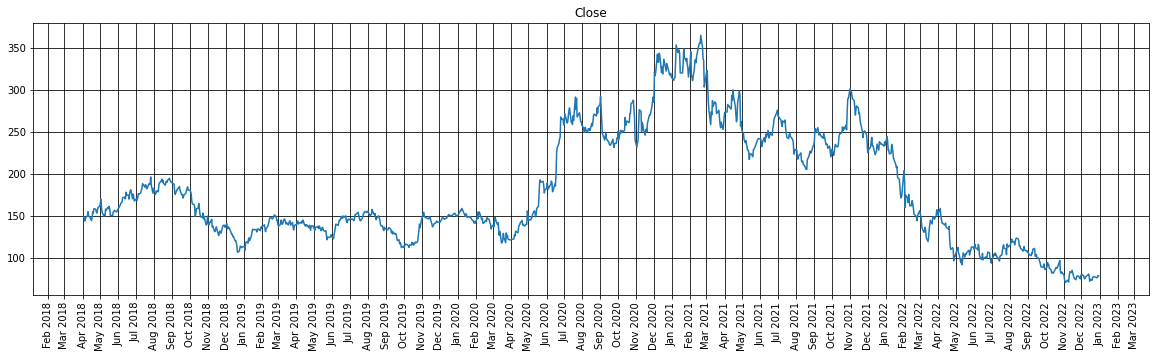

In [10]:
plot_line(df,['Close'])

<h2>Stationarity Check</h2>

In [11]:
# from statsmodels.tsa.stattools import adfuller
# result = adfuller(df['Avg'])
# print(f'Test Statistics: {result[0]}')
# print(f'p-value: {result[1]}')
# print(f'critical_values: {result[4]}')

In [12]:
# if result[1] > 0.05:
#     print("Series is not stationary")
# else:
#     print("Series is stationary")

<h2>Granger Causality</h2>

In [13]:
# from statsmodels.tsa.stattools import grangercausalitytests

# grangercausalitytests(df_agg_loreal[numeric_col], maxlag=4)
# #p-value<0.05 => reject H0 => Media Cost (Original) influence Impressions

<h2>Modeling</h2>

In [14]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1138

In [15]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.26558559],
       [0.24926756],
       [0.24848404],
       ...,
       [0.01894119],
       [0.02711726],
       [0.02691284]])

In [16]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.26558559, 0.24926756, 0.24848404, 0.26187231, 0.26895823,
       0.28565099, 0.26749338, 0.26589223, 0.26555154, 0.24960825,
       0.26381415, 0.28568509, 0.28077945, 0.29774476, 0.296348  ,
       0.28623018, 0.28030252, 0.29144241, 0.30295699, 0.30871431,
       0.31964981, 0.33709205, 0.3043197 , 0.28347071, 0.26895823,
       0.27113851, 0.26919672, 0.29665464, 0.29202154, 0.30292294,
       0.29863053, 0.30776044, 0.29880082, 0.27168359, 0.26970771,
       0.27042308, 0.28384545, 0.28459493, 0.29144241, 0.28469712,
       0.29069293, 0.29522384, 0.30043607, 0.31266608, 0.31992235,
       0.32223887, 0.32356748, 0.34213393, 0.34516589, 0.33787557,
       0.33988556, 0.36468626, 0.35419365, 0.35191117, 0.33671731,
       0.35889485, 0.36955781, 0.37436125, 0.33835251, 0.35746404])]
[0.3444164105644635]

[array([0.26558559, 0.24926756, 0.24848404, 0.26187231, 0.26895823,
       0.28565099, 0.26749338, 0.26589223, 0.26555154, 0.24960825,
       0.26381415, 0.28568509, 0.280

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1078/1078 [==============================] - 38s 31ms/step - loss: 0.0032


In [18]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 24ms/step


5.261577024488367

<ipython-input-21-1b02c5862b2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


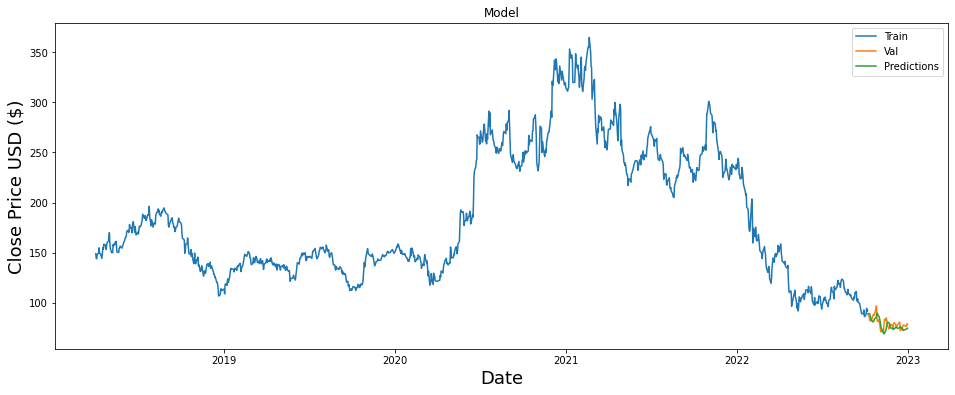

In [21]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [20]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2022-10-07 00:00:00-04:00,88.010002,89.303024
2022-10-10 00:00:00-04:00,85.970001,89.374367
2022-10-11 00:00:00-04:00,82.129997,88.546326
2022-10-12 00:00:00-04:00,83.180000,86.679893
2022-10-13 00:00:00-04:00,82.650002,84.698921
2022-10-14 00:00:00-04:00,81.790001,82.887970
2022-10-17 00:00:00-04:00,86.720001,81.327934
2022-10-18 00:00:00-04:00,88.040001,80.997467
2022-10-19 00:00:00-04:00,88.750000,81.656166
